# Synthetic Data Generation

Generate the four synthetic datasets (32/88/93/181 dimensions) with block-diagonal correlation structure and save them to disk.

In [1]:
# Imports and configuration
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.linalg import cholesky
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

np.random.seed(42)
plt.style.use('seaborn-v0_8-paper')
sns.set_palette('husl')

N_SAMPLES = 2000
TEST_SIZE = 0.2
DATA_DIR = Path('data/synthetic')
DATA_DIR.mkdir(parents=True, exist_ok=True)

print('Configuration ready:')
print(f'  Samples: {N_SAMPLES} (train/test split = {1-TEST_SIZE:.0%}/{TEST_SIZE:.0%})')
print('  Output directory:', DATA_DIR.resolve())

Configuration ready:
  Samples: 2000 (train/test split = 80%/20%)
  Output directory: /Users/eve/Documents/Projects/SCRAM/experiments/data/synthetic


## Helper Functions
We create reusable utilities to define correlation structures, class means, data generation, and dataset persistence.

In [2]:
def create_block_diagonal_correlation(block_sizes, rho_within_list, rho_between=0.05):
    """Build a block-diagonal correlation matrix with customizable within/between block correlations."""
    n_features = sum(block_sizes)
    corr_matrix = np.full((n_features, n_features), rho_between, dtype=float)

    idx = 0
    for block_size, rho_within in zip(block_sizes, rho_within_list):
        block_end = idx + block_size
        corr_matrix[idx:block_end, idx:block_end] = rho_within
        idx = block_end

    np.fill_diagonal(corr_matrix, 1.0)

    eigenvalues = np.linalg.eigvalsh(corr_matrix)
    if np.any(eigenvalues < -1e-10):
        adjustment = abs(eigenvalues.min()) * 1.1
        corr_matrix += np.eye(n_features) * adjustment
        np.fill_diagonal(corr_matrix, 1.0)

    return corr_matrix


def create_egemaps_correlation():
    block_sizes = [8] * 11  # 11 functional groups = 88 features
    rho_within = [0.6, 0.45, 0.45, 0.55, 0.4, 0.4, 0.5, 0.6, 0.35, 0.3, 0.5]
    return create_block_diagonal_correlation(block_sizes, rho_within, rho_between=0.08)


def create_liwc_correlation():
    block_sizes = [8, 8, 8, 7, 8, 7, 7, 7, 8, 7, 7, 7, 4]  # 13 thematic clusters = 93 features
    rho_within = [0.4, 0.5, 0.5, 0.6, 0.45, 0.4, 0.35, 0.35, 0.4, 0.45, 0.3, 0.3, 0.25]
    return create_block_diagonal_correlation(block_sizes, rho_within, rho_between=0.05)


corr_preview_88 = create_egemaps_correlation()
corr_preview_93 = create_liwc_correlation()
print('Correlation builders ready: 88-dim and 93-dim templates validated.')

Correlation builders ready: 88-dim and 93-dim templates validated.


In [3]:
def generate_class_means(n_features, discriminative_ratio=0.5, effect_size=0.45):
    mean_class0 = np.zeros(n_features)
    mean_class1 = np.zeros(n_features)

    n_discriminative = max(1, int(n_features * discriminative_ratio))
    discriminative_indices = np.random.choice(n_features, n_discriminative, replace=False)
    mean_class1[discriminative_indices] = effect_size
    return mean_class0, mean_class1


def generate_synthetic_data(n_samples, n_features, corr_matrix, mean_class0, mean_class1):
    n_class0 = n_samples // 2
    n_class1 = n_samples - n_class0

    try:
        L = cholesky(corr_matrix, lower=True)
    except np.linalg.LinAlgError:
        eigenvalues, eigenvectors = np.linalg.eigh(corr_matrix)
        eigenvalues[eigenvalues < 0] = 1e-10
        L = eigenvectors @ np.diag(np.sqrt(eigenvalues))

    Z0 = np.random.randn(n_class0, n_features)
    Z1 = np.random.randn(n_class1, n_features)

    with np.errstate(divide='ignore', invalid='ignore', over='ignore'):
        X0 = Z0 @ L.T + mean_class0
        X1 = Z1 @ L.T + mean_class1

    if not np.all(np.isfinite(X0)) or not np.all(np.isfinite(X1)):
        raise FloatingPointError('Non-finite values encountered while applying correlation structure.')

    X = np.vstack([X0, X1])
    y = np.hstack([np.zeros(n_class0), np.ones(n_class1)])

    shuffle_idx = np.random.permutation(n_samples)
    return X[shuffle_idx], y[shuffle_idx]


print('Data generation helpers ready.')

Data generation helpers ready.


In [ ]:
# Save dataset to disk
def save_dataset(X_train, X_test, y_train, y_test, n_features):
    dim_dir = DATA_DIR / f'{n_features}dim'
    dim_dir.mkdir(parents=True, exist_ok=True)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    np.save(dim_dir / 'X_train.npy', X_train_scaled)
    np.save(dim_dir / 'X_test.npy', X_test_scaled)
    np.save(dim_dir / 'y_train.npy', y_train)
    np.save(dim_dir / 'y_test.npy', y_test)
    np.save(dim_dir / 'scaler_params.npy', {
        'mean': scaler.mean_.tolist(),
        'scale': scaler.scale_.tolist(),
        'var': scaler.var_.tolist()
    })

    summary = {
        'n_features': n_features,
        'n_train': len(y_train),
        'n_test': len(y_test),
        'class_balance_train': {
            'class_0': int((y_train == 0).sum()),
            'class_1': int((y_train == 1).sum())
        },
        'class_balance_test': {
            'class_0': int((y_test == 0).sum()),
            'class_1': int((y_test == 1).sum())
        }
    }

    with open(dim_dir / 'dataset_summary.json', 'w') as f:
        json.dump(summary, f, indent=2)

    print(f'Saved {n_features}-dim dataset to {dim_dir}')
    
    return summary

## 32-Dimensional Baseline

In [5]:
block_sizes_32 = [8, 8, 8, 8]
rho_within_32 = [0.5, 0.4, 0.45, 0.35]
corr_32 = create_block_diagonal_correlation(block_sizes_32, rho_within_32, rho_between=0.05)

mean_class0_32, mean_class1_32 = generate_class_means(32)
X_32, y_32 = generate_synthetic_data(N_SAMPLES, 32, corr_32, mean_class0_32, mean_class1_32)
X_train_32, X_test_32, y_train_32, y_test_32 = train_test_split(
    X_32, y_32, test_size=TEST_SIZE, stratify=y_32, random_state=42
)
summary_32 = save_dataset(X_train_32, X_test_32, y_train_32, y_test_32, 32)

Saved 32-dim dataset to data/synthetic/32dim


## 88-Dimensional eGeMAPS-like Acoustic Features

In [6]:
corr_88 = create_egemaps_correlation()
mean_class0_88, mean_class1_88 = generate_class_means(88)
X_88, y_88 = generate_synthetic_data(N_SAMPLES, 88, corr_88, mean_class0_88, mean_class1_88)
X_train_88, X_test_88, y_train_88, y_test_88 = train_test_split(
    X_88, y_88, test_size=TEST_SIZE, stratify=y_88, random_state=42
)
summary_88 = save_dataset(X_train_88, X_test_88, y_train_88, y_test_88, 88)

Saved 88-dim dataset to data/synthetic/88dim


## 93-Dimensional LIWC-like Linguistic Features

In [7]:
corr_93 = create_liwc_correlation()
mean_class0_93, mean_class1_93 = generate_class_means(93)
X_93, y_93 = generate_synthetic_data(N_SAMPLES, 93, corr_93, mean_class0_93, mean_class1_93)
X_train_93, X_test_93, y_train_93, y_test_93 = train_test_split(
    X_93, y_93, test_size=TEST_SIZE, stratify=y_93, random_state=42
)
summary_93 = save_dataset(X_train_93, X_test_93, y_train_93, y_test_93, 93)

Saved 93-dim dataset to data/synthetic/93dim


## 181-Dimensional Multimodal (Acoustic + Linguistic)

In [8]:
corr_181 = np.zeros((181, 181))
corr_181[:88, :88] = corr_88
corr_181[88:, 88:] = corr_93
corr_181[:88, 88:] = 0.03
corr_181[88:, :88] = 0.03
np.fill_diagonal(corr_181, 1.0)

eigvals = np.linalg.eigvalsh(corr_181)
if np.any(eigvals < -1e-10):
    corr_181 += np.eye(181) * abs(eigvals.min()) * 1.1
    np.fill_diagonal(corr_181, 1.0)

mean_class0_181, mean_class1_181 = generate_class_means(181)
X_181, y_181 = generate_synthetic_data(N_SAMPLES, 181, corr_181, mean_class0_181, mean_class1_181)
X_train_181, X_test_181, y_train_181, y_test_181 = train_test_split(
    X_181, y_181, test_size=TEST_SIZE, stratify=y_181, random_state=42
)
summary_181 = save_dataset(X_train_181, X_test_181, y_train_181, y_test_181, 181)

Saved 181-dim dataset to data/synthetic/181dim


## Correlation Structure Visualization

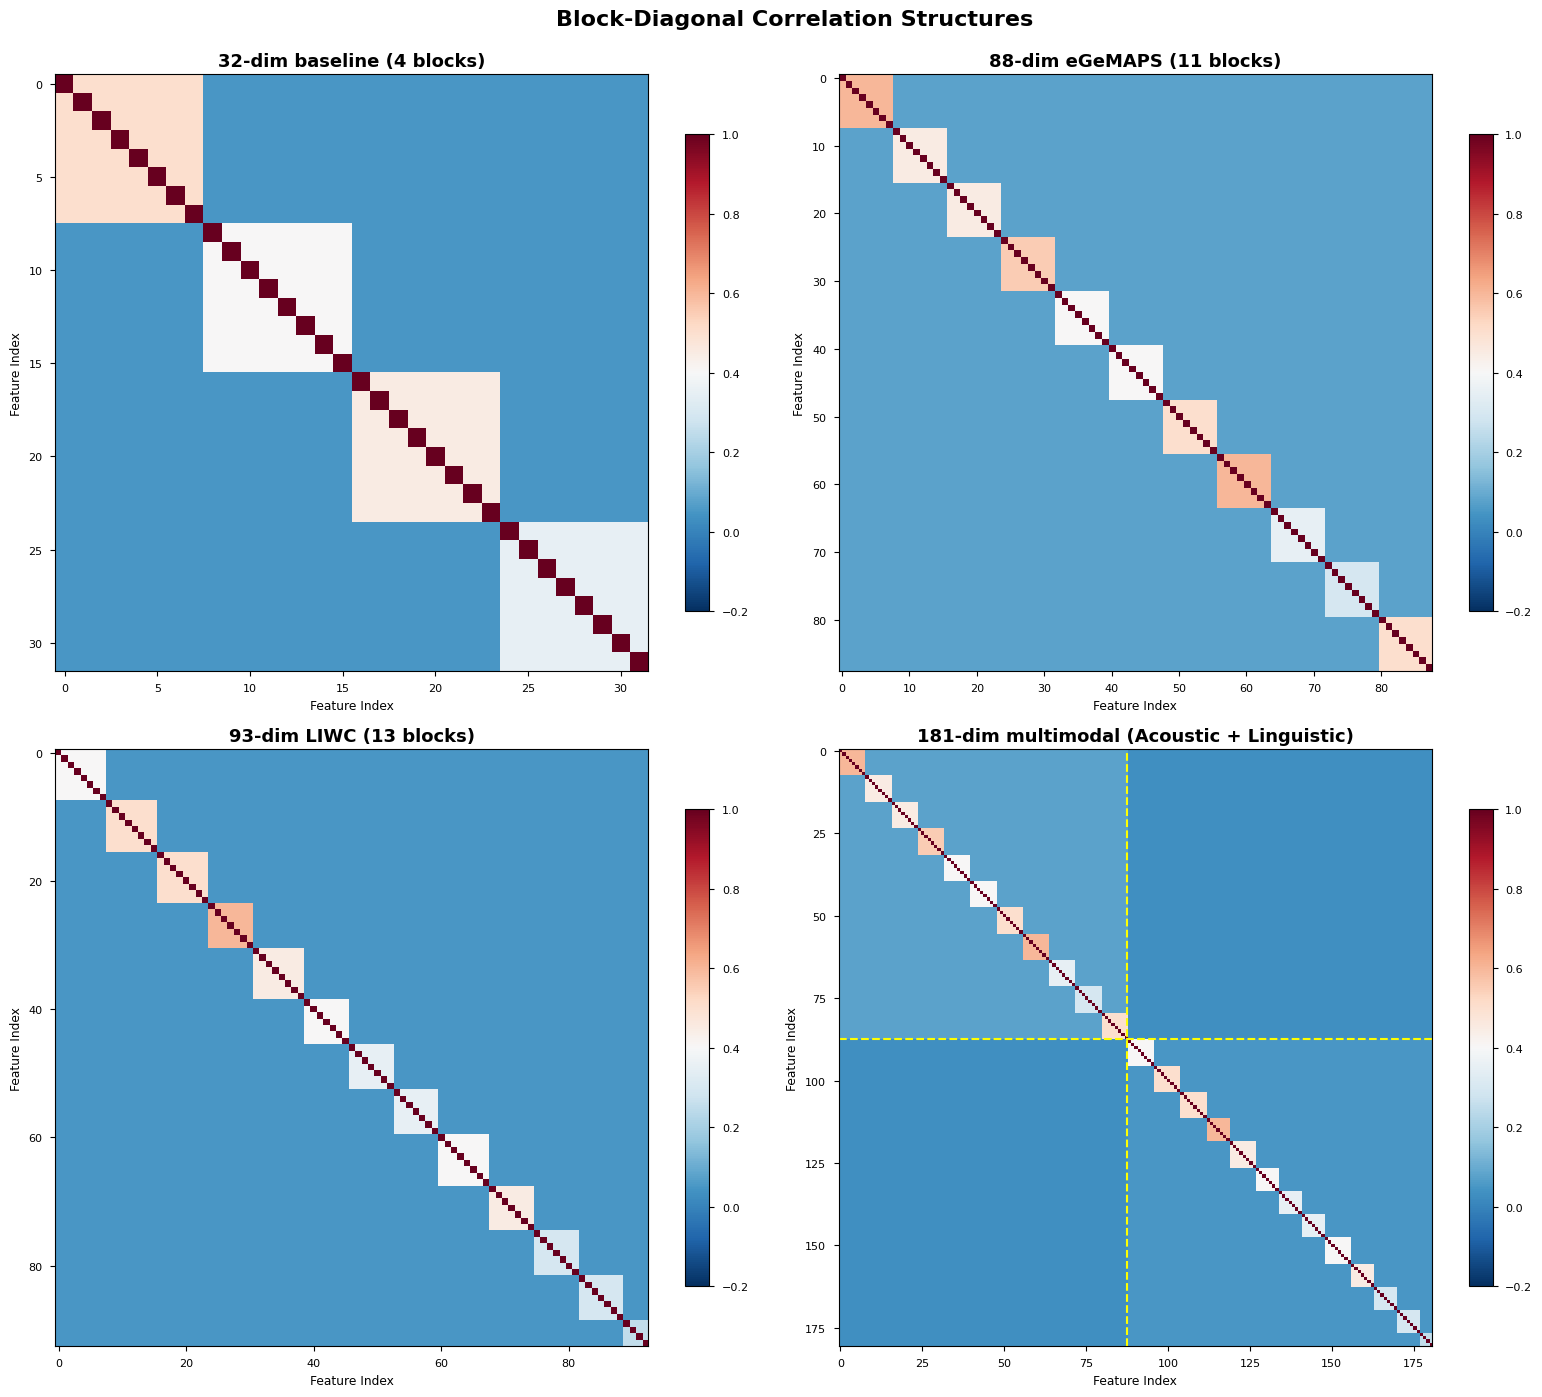

Saved correlation_comparison.png to data/synthetic


In [9]:
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
plots = [
    (corr_32, '32-dim baseline (4 blocks)'),
    (corr_88, '88-dim eGeMAPS (11 blocks)'),
    (corr_93, '93-dim LIWC (13 blocks)'),
    (corr_181, '181-dim multimodal (Acoustic + Linguistic)')
]

for ax, (matrix, title) in zip(axes.flatten(), plots):
    im = ax.imshow(matrix, cmap='RdBu_r', vmin=-0.2, vmax=1, aspect='auto')
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.set_xlabel('Feature Index')
    ax.set_ylabel('Feature Index')
    plt.colorbar(im, ax=ax, shrink=0.8)

axes[1, 1].axhline(87.5, color='yellow', linestyle='--', linewidth=1.5)
axes[1, 1].axvline(87.5, color='yellow', linestyle='--', linewidth=1.5)

plt.suptitle('Block-Diagonal Correlation Structures', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(DATA_DIR / 'correlation_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved correlation_comparison.png to data/synthetic')

## Dataset Summary

In [12]:
all_summaries = pd.DataFrame({
    'Dataset': ['32-dim', '88-dim', '93-dim', '181-dim'],
    'Features': [32, 88, 93, 181],
    'Train Samples': [summary_32['n_train'], summary_88['n_train'], summary_93['n_train'], summary_181['n_train']],
    'Test Samples': [summary_32['n_test'], summary_88['n_test'], summary_93['n_test'], summary_181['n_test']],
    'Feature Blocks': [
        '4 acoustic clusters',
        '11 eGeMAPS clusters',
        '13 LIWC clusters',
        'Acoustic + Linguistic'
    ]
})

display(all_summaries)
all_summaries.to_csv(DATA_DIR / 'all_datasets_summary.csv', index=False)
print('Saved all_datasets_summary.csv to data/synthetic')

,Dataset,Features,Train Samples,Test Samples,Feature Blocks
0,32-dim,32,1600,400,4 acoustic clusters
1,88-dim,88,1600,400,11 eGeMAPS clusters
2,93-dim,93,1600,400,13 LIWC clusters
3,181-dim,181,1600,400,Acoustic + Linguistic


Saved all_datasets_summary.csv to data/synthetic


## Notes
- Synthetic datasets are stored under `experiments/data/synthetic/*dim` folders. These may have to be manually created before running.
- The subsequent notebooks load from these folders for plaintext and encrypted baselines.